In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import random as random
import torchvision
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
batch_size = 32
epochs = 5
buffer_size = 10000
reinit_freq = 0.05 
sgld_steps = 60
sgld_lr = 0.1
sgld_std = 0.01
img_shape = (1, 320, 320)
alpha = 0.1
lr = 1e-4
beta1 = 0.0

replay_buffer = torch.empty(buffer_size, 1, 320, 320, device=device).normal_(0, 1)

In [3]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((320, 320)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.ImageFolder(root="/work/home/maben/project/blue_whale_lab/projects/ebm_tutorial/ebm_toy_example/data/Breast_Cancer/train", transform=transform)
val_dataset = datasets.ImageFolder(root="/work/home/maben/project/blue_whale_lab/projects/ebm_tutorial/ebm_toy_example/data/Breast_Cancer/valid", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [40]:
print(len(train_dataset))

2372


In [41]:
print(len(val_dataset))

675


In [4]:
class Swish(nn.Module):

    def forward(self, x):
        return x * torch.sigmoid(x)

class CNNModel(nn.Module):

    def __init__(self, hidden_features=32, out_dim=1, **kwargs):
        super().__init__()
        
        c_hid1 = hidden_features//4
        c_hid2 = hidden_features//2
        c_hid3 = hidden_features
        c_hid4 = hidden_features*2
        c_hid5 = hidden_features*4

        self.cnn_layers = nn.Sequential(
                nn.Conv2d(1, c_hid1, kernel_size=5, stride=2, padding=4), # [320x320]
                Swish(),
                nn.Conv2d(c_hid1, c_hid2, kernel_size=3, stride=2, padding=1), #  [160x160]
                Swish(),
                nn.Conv2d(c_hid2, c_hid3, kernel_size=3, stride=2, padding=1), # [80x80]
                Swish(),
                nn.Conv2d(c_hid3, c_hid4, kernel_size=3, stride=2, padding=1), # [40x40]
                Swish(),
                nn.Conv2d(c_hid4, c_hid5, kernel_size=3, stride=2, padding=1), # [20x20]
                Swish(),
                nn.Conv2d(c_hid5, c_hid5, kernel_size=3, stride=2, padding=1), # [10x10]
                Swish(),

        )
        self.fcn = nn.Sequential(
                nn.Flatten(),
                nn.Linear(c_hid5*36, c_hid5),
                Swish(),
                nn.Linear(c_hid5, c_hid5//4),
                Swish(),
                nn.Linear(c_hid5//4, out_dim)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fcn(x).squeeze(dim=-1)
        return x

In [18]:
class LinearModel(nn.Module):

    def __init__(self, hidden_features=32, out_dim=1, **kwargs):
        super().__init__()
        
        self.fcn = nn.Sequential(
                nn.Flatten(),
                nn.Linear(320*320, 1024),
                Swish(),                
                nn.Linear(1024, 512),
                Swish(),
                nn.Linear(512, 128),
                Swish(),
                nn.Linear(128, out_dim)
        )

    def forward(self, x):
        x = self.fcn(x).squeeze(dim=-1)
        return x

In [5]:
class Sampler:

    def __init__(self, model, img_shape, sample_size, max_len=8192):
        """
        inputs:
            model - Neural network to use for modeling E_theta
            img_shape - Shape of the images to model
            sample_size - Batch size of the samples
            max_len - Maximum number of data points to keep in the buffer
        """
        super().__init__()
        self.model = model
        self.img_shape = img_shape
        self.sample_size = sample_size # same as the batch size
        self.max_len = max_len
        self.examples = [(torch.rand((1,)+img_shape)*2-1) for _ in range(self.sample_size)]

    def sample_new_exmps(self, steps=60, step_size=10):
        """
        generates fake samples using the replay buffer and MCMC
        """
        device = next(self.model.parameters()).device 

        ## see on the training algo - 95% of chances to get from the buffer and 5% from random noise
        n_new = np.random.binomial(self.sample_size, 0.05)
        rand_imgs = torch.rand((n_new,) + self.img_shape, device=device) * 2 - 1
        old_imgs = torch.cat(random.choices(self.examples, k=self.sample_size - n_new), dim=0).to(device)
        inp_imgs = torch.cat([rand_imgs, old_imgs], dim=0).detach()

        ## MCMC sampling
        inp_imgs = Sampler.generate_samples(self.model, inp_imgs, steps=steps, step_size=step_size)

        ## update buffer
        self.examples = list(inp_imgs.cpu().chunk(self.sample_size, dim=0)) + self.examples
        self.examples = self.examples[:self.max_len]
        return inp_imgs

    @staticmethod
    def generate_samples(model, inp_imgs, steps=60, step_size=10, return_img_per_step=False):
        """
        MCMC step
        """
        device = inp_imgs.device
        is_training = model.training
        model.eval()

        #before MCMC: freeze the model
        #we are only interested in the gradients of the input.
        for p in model.parameters():
            p.requires_grad = False
        inp_imgs.requires_grad = True

        had_gradients_enabled = torch.is_grad_enabled()
        torch.set_grad_enabled(True)

        noise = torch.randn(inp_imgs.shape, device=device) 

        imgs_per_step = []

        for _ in range(steps): #the MCMC interation steps
            noise.normal_(0, 0.005)
            inp_imgs.data.add_(noise.data)
            inp_imgs.data.clamp_(min=-1.0, max=1.0)

            out_imgs = -model(inp_imgs)
            out_imgs.sum().backward()
            inp_imgs.grad.data.clamp_(-0.03, 0.03)

            inp_imgs.data.add_(-step_size * inp_imgs.grad.data)
            inp_imgs.grad.detach_()
            inp_imgs.grad.zero_()
            inp_imgs.data.clamp_(min=-1.0, max=1.0)

            if return_img_per_step:
                imgs_per_step.append(inp_imgs.clone().detach())

        for p in model.parameters():
            p.requires_grad = True
        model.train(is_training)
        torch.set_grad_enabled(had_gradients_enabled)

        if return_img_per_step:
            return torch.stack(imgs_per_step, dim=0)
        else:
            return inp_imgs

In [6]:
hidden_features = 128
cnn = CNNModel(hidden_features=hidden_features).to(device)
sampler = Sampler(cnn, img_shape=img_shape, sample_size=batch_size)

optimizer = optim.Adam(cnn.parameters(), lr=1e-4, betas=(0.0, 0.999))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.97)

In [19]:
hidden_features = 128
linear = LinearModel(hidden_features=hidden_features).to(device)
sampler = Sampler(linear, img_shape=img_shape, sample_size=batch_size)

optimizer = optim.Adam(linear.parameters(), lr=1e-4, betas=(0.0, 0.999))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.97)

In [7]:
def train_step(real_imgs, cnn, sampler, optimizer, alpha):
    small_noise = torch.randn_like(real_imgs) * 0.005
    real_imgs = real_imgs + small_noise
    real_imgs = real_imgs.clamp(min=-1.0, max=1.0)

    fake_imgs = sampler.sample_new_exmps(steps=60, step_size=10)

    inp_imgs = torch.cat([real_imgs, fake_imgs], dim=0)
    real_out, fake_out = cnn(inp_imgs).chunk(2, dim=0)

    reg_loss = alpha * (real_out ** 2 + fake_out ** 2).mean()
    cdiv_loss = fake_out.mean() - real_out.mean()
    loss = reg_loss + cdiv_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item(), reg_loss.item(), cdiv_loss.item(), real_out.mean().item(), fake_out.mean().item()

In [8]:
def validate(val_loader, cnn):
    cnn.eval()
    cdivs, fake_outs, real_outs = [], [], []
    with torch.no_grad():
        for real_imgs, _ in val_loader:
            real_imgs = real_imgs.to(device)
            fake_imgs = torch.rand_like(real_imgs) * 2 - 1
            inp_imgs = torch.cat([real_imgs, fake_imgs], dim=0)
            real_out, fake_out = cnn(inp_imgs).chunk(2, dim=0)

            cdiv = fake_out.mean() - real_out.mean()
            cdivs.append(cdiv.item())
            fake_outs.append(fake_out.mean().item())
            real_outs.append(real_out.mean().item())
    return cdivs, fake_outs, real_outs

In [11]:
for epoch in range(epochs):
    cnn.train()
    train_loss, reg_loss, cdiv_loss = 0, 0, 0
    avg_real_out, avg_fake_out = 0, 0

    for real_imgs, _ in train_loader:
        real_imgs = real_imgs.to(device)
        loss, r_loss, c_loss, r_out, f_out = train_step(real_imgs, cnn, sampler, optimizer, alpha)
        train_loss += loss
        reg_loss += r_loss
        cdiv_loss += c_loss
        avg_real_out += r_out
        avg_fake_out += f_out

    scheduler.step()

    cdivs, fake_outs, real_outs = validate(val_loader, cnn)

    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Train Loss: {train_loss/len(train_loader):.4f}, Reg Loss: {reg_loss/len(train_loader):.4f}, CDiv Loss: {cdiv_loss/len(train_loader):.4f}")
    print(f"Avg Real Out: {avg_real_out/len(train_loader):.4f}, Avg Fake Out: {avg_fake_out/len(train_loader):.4f}")
    print(f"Val CDiv: {sum(cdivs)/len(cdivs):.4f}, Val Real Out: {sum(real_outs)/len(real_outs):.4f}, Val Fake Out: {sum(fake_outs)/len(fake_outs):.4f}")

Epoch 1/5
Train Loss: -4.7559, Reg Loss: 4.8311, CDiv Loss: -9.5870
Avg Real Out: 4.6827, Avg Fake Out: -4.9044
Val CDiv: -1.6919, Val Real Out: 2.7104, Val Fake Out: 1.0185
Epoch 2/5
Train Loss: -4.5366, Reg Loss: 4.5437, CDiv Loss: -9.0803
Avg Real Out: 4.5770, Avg Fake Out: -4.5033
Val CDiv: -3.5192, Val Real Out: 4.2503, Val Fake Out: 0.7312
Epoch 3/5
Train Loss: -4.6795, Reg Loss: 4.6352, CDiv Loss: -9.3147
Avg Real Out: 4.7066, Avg Fake Out: -4.6081
Val CDiv: -4.7110, Val Real Out: 4.8177, Val Fake Out: 0.1067
Epoch 4/5
Train Loss: -4.6840, Reg Loss: 4.6846, CDiv Loss: -9.3686
Avg Real Out: 4.7095, Avg Fake Out: -4.6591
Val CDiv: -6.8840, Val Real Out: 5.5543, Val Fake Out: -1.3297
Epoch 5/5
Train Loss: -4.6622, Reg Loss: 4.6678, CDiv Loss: -9.3300
Avg Real Out: 4.6694, Avg Fake Out: -4.6606
Val CDiv: -7.6094, Val Real Out: 5.0774, Val Fake Out: -2.5320


In [20]:
for epoch in range(epochs):
    linear.train()
    train_loss, reg_loss, cdiv_loss = 0, 0, 0
    avg_real_out, avg_fake_out = 0, 0

    for real_imgs, _ in train_loader:
        real_imgs = real_imgs.to(device)
        loss, r_loss, c_loss, r_out, f_out = train_step(real_imgs, linear, sampler, optimizer, alpha)
        train_loss += loss
        reg_loss += r_loss
        cdiv_loss += c_loss
        avg_real_out += r_out
        avg_fake_out += f_out

    scheduler.step()

    cdivs, fake_outs, real_outs = validate(val_loader, linear)

    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Train Loss: {train_loss/len(train_loader):.4f}, Reg Loss: {reg_loss/len(train_loader):.4f}, CDiv Loss: {cdiv_loss/len(train_loader):.4f}")
    print(f"Avg Real Out: {avg_real_out/len(train_loader):.4f}, Avg Fake Out: {avg_fake_out/len(train_loader):.4f}")
    print(f"Val CDiv: {sum(cdivs)/len(cdivs):.4f}, Val Real Out: {sum(real_outs)/len(real_outs):.4f}, Val Fake Out: {sum(fake_outs)/len(fake_outs):.4f}")

Epoch 1/5
Train Loss: -2.5520, Reg Loss: 3.2481, CDiv Loss: -5.8000
Avg Real Out: 4.1085, Avg Fake Out: -1.6915
Val CDiv: -5.1701, Val Real Out: 5.0624, Val Fake Out: -0.1077
Epoch 2/5
Train Loss: -3.0664, Reg Loss: 3.9743, CDiv Loss: -7.0407
Avg Real Out: 4.4150, Avg Fake Out: -2.6257
Val CDiv: -4.4530, Val Real Out: 4.3071, Val Fake Out: -0.1459
Epoch 3/5
Train Loss: -3.8928, Reg Loss: 3.7602, CDiv Loss: -7.6531
Avg Real Out: 4.5429, Avg Fake Out: -3.1102
Val CDiv: -4.8442, Val Real Out: 4.6602, Val Fake Out: -0.1840
Epoch 4/5
Train Loss: -3.3478, Reg Loss: 3.5316, CDiv Loss: -6.8794
Avg Real Out: 4.3367, Avg Fake Out: -2.5427
Val CDiv: -3.8640, Val Real Out: 3.6406, Val Fake Out: -0.2234
Epoch 5/5
Train Loss: -3.3589, Reg Loss: 3.0254, CDiv Loss: -6.3844
Avg Real Out: 4.2577, Avg Fake Out: -2.1267
Val CDiv: -4.6030, Val Real Out: 4.3203, Val Fake Out: -0.2827


# Testing EBM

In [12]:
with torch.no_grad():
    rand_imgs = torch.rand((128,) + img_shape).to(device)
    rand_imgs = rand_imgs * 2 - 1.0
    rand_out = cnn(rand_imgs).mean()
    print(f"Average score for random images: {rand_out.item():4.2f}")

Average score for random images: -2.53


In [13]:
with torch.no_grad():
    train_imgs,_ = next(iter(train_loader))
    train_imgs = train_imgs.to(device)
    train_out = cnn(train_imgs).mean()
    print(f"Average score for training images: {train_out.item():4.2f}")

Average score for training images: 4.97


In [21]:
with torch.no_grad():
    rand_imgs = torch.rand((128,) + img_shape).to(device)
    rand_imgs = rand_imgs * 2 - 1.0
    rand_out = linear(rand_imgs).mean()
    print(f"Average score for random images: {rand_out.item():4.2f}")

Average score for random images: -0.28


In [22]:
with torch.no_grad():
    train_imgs,_ = next(iter(train_loader))
    train_imgs = train_imgs.to(device)
    train_out = linear(train_imgs).mean()
    print(f"Average score for training images: {train_out.item():4.2f}")

Average score for training images: 4.45


In [27]:
@torch.no_grad()
def compare_images(img1, img2):
    imgs = torch.stack([img1, img2], dim=0).to(device)
    score1, score2 = linear(imgs).cpu().chunk(2, dim=0)
    grid = torchvision.utils.make_grid([img1.cpu(), img2.cpu()], nrow=2, normalize=True, pad_value=0.5, padding=2)
    grid = grid.permute(1, 2, 0)

    plt.figure(figsize=(6, 6))
    plt.imshow(grid)
    plt.xticks([(img1.shape[2] + 2) * (0.5 + j) for j in range(2)],
               labels=["Original image", "Transformed image"], fontsize=10)
    plt.yticks([])

    plt.text(0, -20, f"Score original image: {score1.item():4.2f}",
             color="white", fontsize=12, ha='left', va='bottom', bbox=dict(facecolor='black', alpha=0.6))
    plt.text(img1.shape[2] + 10, -20, f"Score transformed image: {score2.item():4.2f}",
             color="white", fontsize=12, ha='left', va='bottom', bbox=dict(facecolor='black', alpha=0.6))

    plt.show()

In [28]:
test_imgs, _ = next(iter(val_loader))
exmp_img = test_imgs[0].to(device)

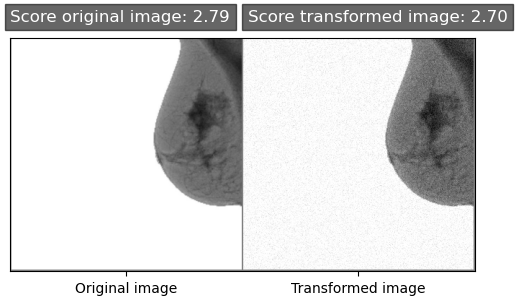

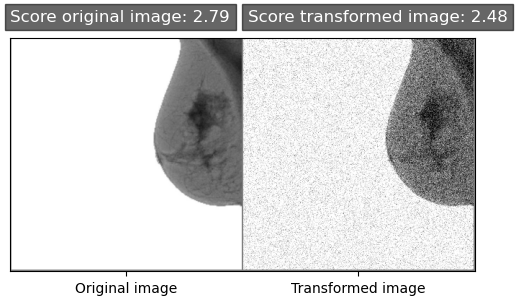

In [29]:
#noise_rates = [0.1,0.3,0.5,0.7,0.9,1.1,1.3,1.5]
noise_rates = [0.1,0.3]
for noise_rate in noise_rates:
    img_noisy = exmp_img + torch.randn_like(exmp_img) * noise_rate #same image with some noise
    img_noisy.clamp_(min=-1.0, max=1.0)
    compare_images(exmp_img, img_noisy)

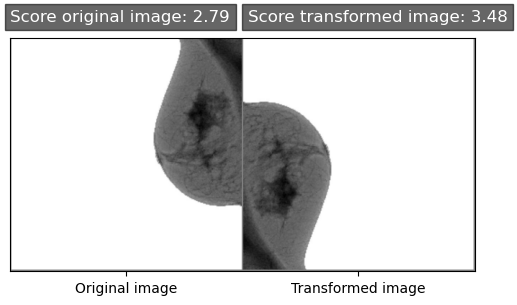

In [30]:
img_flipped = exmp_img.flip(dims=(1,2))
compare_images(exmp_img, img_flipped)

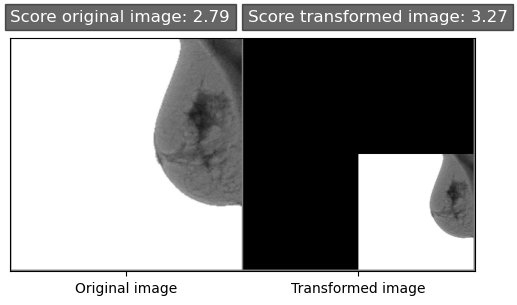

In [31]:
img_tiny = torch.zeros_like(exmp_img)-1
img_tiny[:,exmp_img.shape[1]//2:,exmp_img.shape[2]//2:] = exmp_img[:,::2,::2]
compare_images(exmp_img, img_tiny)

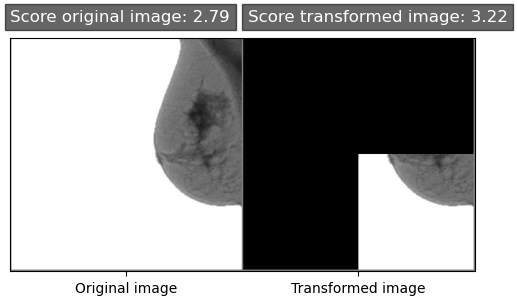

In [32]:
mask = torch.zeros_like(exmp_img[0], dtype=torch.bool) 
mask[exmp_img.shape[1]//2:, exmp_img.shape[2]//2:] = True 

img_masked = exmp_img.clone()
img_masked[:, ~mask] = -1 

compare_images(exmp_img, img_masked)

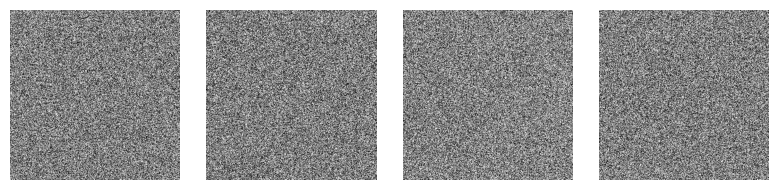

In [39]:
def generate_images(model, sampler, num_images=16, steps=60000, step_size=1):
    model.eval()
    with torch.no_grad():
        generated_imgs = sampler.sample_new_exmps(steps=steps, step_size=step_size)
        generated_imgs = generated_imgs[:num_images].detach() 

    return generated_imgs.cpu()

def plot_generated_images(images, num_cols=4):
    num_images = images.size(0)
    num_rows = (num_images + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < num_images:
            img = images[i].squeeze(0).numpy() 
            ax.imshow(img, cmap="gray")
            ax.axis("off")
        else:
            ax.axis("off")
    plt.tight_layout()
    plt.show()

num_images = 4
generated_images = generate_images(cnn, sampler, num_images=num_images, steps=100000, step_size=0.01)

plot_generated_images(generated_images)

# JEMs

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import random as random
import torchvision
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_shape = (1, 28, 28)
batch_size = 64
num_classes = 10
lr = 1e-4
beta1 = 0.0
alpha = 0.1 
epochs = 10

class Swish(nn.Module):

    def forward(self, x):
        return x * torch.sigmoid(x)
        
class JEMClassifier(nn.Module):
    def __init__(self, hidden_features=32):
        super().__init__()
        c_hid1 = hidden_features // 2
        c_hid2 = hidden_features
        c_hid3 = hidden_features * 2

        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1, c_hid1, kernel_size=5, stride=2, padding=4),  # [16x16]
            Swish(),
            nn.Conv2d(c_hid1, c_hid2, kernel_size=3, stride=2, padding=1),  # [8x8]
            Swish(),
            nn.Conv2d(c_hid2, c_hid3, kernel_size=3, stride=2, padding=1),  # [4x4]
            Swish(),
            nn.Conv2d(c_hid3, c_hid3, kernel_size=3, stride=2, padding=1),  # [2x2]
            Swish(),
            nn.Flatten()
        )
        self.fc_energy = nn.Linear(c_hid3 * 4, 1) 
        self.fc_class = nn.Linear(c_hid3 * 4, num_classes)

    def forward(self, x):
        features = self.cnn_layers(x)
        energy = self.fc_energy(features).squeeze(-1)
        logits = self.fc_class(features)
        return energy, logits

In [45]:
class Sampler:

    def __init__(self, model, img_shape, sample_size, max_len=8192):
        """
        inputs:
            model - Neural network to use for modeling E_theta
            img_shape - Shape of the images to model
            sample_size - Batch size of the samples
            max_len - Maximum number of data points to keep in the buffer
        """
        super().__init__()
        self.model = model
        self.img_shape = img_shape
        self.sample_size = sample_size # same as the batch size
        self.max_len = max_len
        self.examples = [(torch.rand((1,)+img_shape)*2-1) for _ in range(self.sample_size)]

    def sample_new_exmps(self, steps=60, step_size=10):
        """
        generates fake samples using the replay buffer and MCMC
        """
        device = next(self.model.parameters()).device 

        ## see on the training algo - 95% of chances to get from the buffer and 5% from random noise
        n_new = np.random.binomial(self.sample_size, 0.05)
        rand_imgs = torch.rand((n_new,) + self.img_shape, device=device) * 2 - 1
        old_imgs = torch.cat(random.choices(self.examples, k=self.sample_size - n_new), dim=0).to(device)
        inp_imgs = torch.cat([rand_imgs, old_imgs], dim=0).detach()

        ## MCMC sampling
        inp_imgs = Sampler.generate_samples(self.model, inp_imgs, steps=steps, step_size=step_size)

        ## update buffer
        self.examples = list(inp_imgs.cpu().chunk(self.sample_size, dim=0)) + self.examples
        self.examples = self.examples[:self.max_len]
        return inp_imgs

    @staticmethod
    def generate_samples(model, inp_imgs, steps=60, step_size=10, return_img_per_step=False):
        """
        MCMC step
        """
        device = inp_imgs.device
        is_training = model.training
        model.eval()

        #before MCMC: freeze the model
        #we are only interested in the gradients of the input.
        for p in model.parameters():
            p.requires_grad = False
        inp_imgs.requires_grad = True

        had_gradients_enabled = torch.is_grad_enabled()
        torch.set_grad_enabled(True)

        noise = torch.randn(inp_imgs.shape, device=device) 

        imgs_per_step = []

        for _ in range(steps): #the MCMC interation steps
            noise.normal_(0, 0.005)
            inp_imgs.data.add_(noise.data)
            inp_imgs.data.clamp_(min=-1.0, max=1.0)

            out_imgs = -model(inp_imgs)[0] #only modification from the usual EBM sampler
            out_imgs.sum().backward()
            inp_imgs.grad.data.clamp_(-0.03, 0.03)

            inp_imgs.data.add_(-step_size * inp_imgs.grad.data)
            inp_imgs.grad.detach_()
            inp_imgs.grad.zero_()
            inp_imgs.data.clamp_(min=-1.0, max=1.0)

            if return_img_per_step:
                imgs_per_step.append(inp_imgs.clone().detach())

        for p in model.parameters():
            p.requires_grad = True
        model.train(is_training)
        torch.set_grad_enabled(had_gradients_enabled)

        if return_img_per_step:
            return torch.stack(imgs_per_step, dim=0)
        else:
            return inp_imgs

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root="/work/home/maben/project/blue_whale_lab/projects/pareto_ebm/project/datasets", train=True, transform=transform, download=True)
val_dataset = datasets.MNIST(root="/work/home/maben/project/blue_whale_lab/projects/pareto_ebm/project/datasets", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = JEMClassifier(hidden_features=32).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(beta1, 0.999))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.97)
sampler = Sampler(model, img_shape=(1, 28, 28), sample_size=batch_size)


def jem_loss(energy_real, energy_fake, logits, labels, alpha):
    min_batch_size = min(energy_real.size(0), energy_fake.size(0))
    energy_real = energy_real[:min_batch_size]
    energy_fake = energy_fake[:min_batch_size]

    reg_loss = alpha * (energy_real ** 2 + energy_fake ** 2).mean()
    cdiv_loss = energy_fake.mean() - energy_real.mean()

    class_loss = nn.CrossEntropyLoss()(logits, labels)

    total_loss = reg_loss + cdiv_loss + class_loss
    return total_loss, reg_loss, cdiv_loss, class_loss

In [47]:
for epoch in range(epochs):
    model.train()
    train_loss, reg_loss, cdiv_loss, class_loss = 0, 0, 0, 0

    for real_imgs, labels in train_loader:
        real_imgs, labels = real_imgs.to(device), labels.to(device)

        small_noise = torch.randn_like(real_imgs) * 0.005
        real_imgs = real_imgs + small_noise
        real_imgs = real_imgs.clamp(min=-1.0, max=1.0)

        fake_imgs = sampler.sample_new_exmps(steps=60, step_size=10)

        energy_real, logits_real = model(real_imgs)
        energy_fake, _ = model(fake_imgs)

        loss, r_loss, c_loss, cls_loss = jem_loss(
            energy_real, energy_fake, logits_real, labels, alpha
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        reg_loss += r_loss.item()
        cdiv_loss += c_loss.item()
        class_loss += cls_loss.item()

    scheduler.step()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for val_imgs, val_labels in val_loader:
            val_imgs, val_labels = val_imgs.to(device), val_labels.to(device)
            _, logits_val = model(val_imgs)
            predictions = torch.argmax(logits_val, dim=1)
            correct += (predictions == val_labels).sum().item()
            total += val_labels.size(0)

    accuracy = correct / total
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Train Loss: {train_loss / len(train_loader):.4f}, Reg Loss: {reg_loss / len(train_loader):.4f}, "
          f"CDiv Loss: {cdiv_loss / len(train_loader):.4f}, Class Loss: {class_loss / len(train_loader):.4f}")
    print(f"Validation Accuracy: {accuracy:.4f}")

Epoch 1/10
Train Loss: 1.0199, Reg Loss: 0.0604, CDiv Loss: -0.0970, Class Loss: 1.0565
Validation Accuracy: 0.8354
Epoch 2/10
Train Loss: 0.4847, Reg Loss: 0.0138, CDiv Loss: 0.0262, Class Loss: 0.4447
Validation Accuracy: 0.8854
Epoch 3/10
Train Loss: 0.3631, Reg Loss: 0.0073, CDiv Loss: 0.0327, Class Loss: 0.3232
Validation Accuracy: 0.9191
Epoch 4/10
Train Loss: 0.2839, Reg Loss: 0.0052, CDiv Loss: 0.0247, Class Loss: 0.2539
Validation Accuracy: 0.9343
Epoch 5/10
Train Loss: 0.2337, Reg Loss: 0.0050, CDiv Loss: 0.0211, Class Loss: 0.2076
Validation Accuracy: 0.9469
Epoch 6/10
Train Loss: 0.1949, Reg Loss: 0.0046, CDiv Loss: 0.0175, Class Loss: 0.1729
Validation Accuracy: 0.9559
Epoch 7/10
Train Loss: 0.1669, Reg Loss: 0.0035, CDiv Loss: 0.0153, Class Loss: 0.1482
Validation Accuracy: 0.9626
Epoch 8/10
Train Loss: 0.1456, Reg Loss: 0.0038, CDiv Loss: 0.0117, Class Loss: 0.1301
Validation Accuracy: 0.9652
Epoch 9/10
Train Loss: 0.1283, Reg Loss: 0.0036, CDiv Loss: 0.0080, Class Loss:

In [48]:
class SimpleClassifier(nn.Module):
    def __init__(self, hidden_features=32, num_classes=10):
        super().__init__()
        c_hid1 = hidden_features // 2
        c_hid2 = hidden_features
        c_hid3 = hidden_features * 2

        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1, c_hid1, kernel_size=5, stride=2, padding=4),  # [16x16]
            Swish(),
            nn.Conv2d(c_hid1, c_hid2, kernel_size=3, stride=2, padding=1),  # [8x8]
            Swish(),
            nn.Conv2d(c_hid2, c_hid3, kernel_size=3, stride=2, padding=1),  # [4x4]
            Swish(),
            nn.Conv2d(c_hid3, c_hid3, kernel_size=3, stride=2, padding=1),  # [2x2]
            Swish(),
            nn.Flatten()
        )
        self.fc_class = nn.Linear(c_hid3 * 4, num_classes)

    def forward(self, x):
        features = self.cnn_layers(x)
        logits = self.fc_class(features)
        return logits


simple_model = SimpleClassifier(hidden_features=32).to(device)
optimizer = optim.Adam(simple_model.parameters(), lr=lr, betas=(beta1, 0.999))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.97)
criterion = nn.CrossEntropyLoss()

for epoch in range(10):
    simple_model.train()
    train_loss = 0
    for real_imgs, labels in train_loader:
        real_imgs, labels = real_imgs.to(device), labels.to(device)

        logits = simple_model(real_imgs)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    scheduler.step()

    simple_model.eval()
    correct = 0
    total = 0
    predictions_list = []
    confidences_list = []
    labels_list = []
    with torch.no_grad():
        for val_imgs, val_labels in val_loader:
            val_imgs, val_labels = val_imgs.to(device), val_labels.to(device)
            logits = simple_model(val_imgs)
            probabilities = torch.softmax(logits, dim=1)
            predictions = torch.argmax(probabilities, dim=1)

            confidences_list.append(probabilities.max(dim=1).values.cpu())
            predictions_list.append(predictions.cpu())
            labels_list.append(val_labels.cpu())

            correct += (predictions == val_labels).sum().item()
            total += val_labels.size(0)

    accuracy = correct / total
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss / len(train_loader):.4f}, Validation Accuracy: {accuracy:.4f}")

all_confidences = torch.cat(confidences_list)
all_predictions = torch.cat(predictions_list)
all_labels = torch.cat(labels_list)

Epoch 1/10, Train Loss: 0.7377, Validation Accuracy: 0.8971
Epoch 2/10, Train Loss: 0.2879, Validation Accuracy: 0.9350
Epoch 3/10, Train Loss: 0.2014, Validation Accuracy: 0.9461
Epoch 4/10, Train Loss: 0.1525, Validation Accuracy: 0.9543
Epoch 5/10, Train Loss: 0.1230, Validation Accuracy: 0.9672
Epoch 6/10, Train Loss: 0.1025, Validation Accuracy: 0.9726
Epoch 7/10, Train Loss: 0.0894, Validation Accuracy: 0.9756
Epoch 8/10, Train Loss: 0.0788, Validation Accuracy: 0.9770
Epoch 9/10, Train Loss: 0.0713, Validation Accuracy: 0.9788
Epoch 10/10, Train Loss: 0.0648, Validation Accuracy: 0.9802


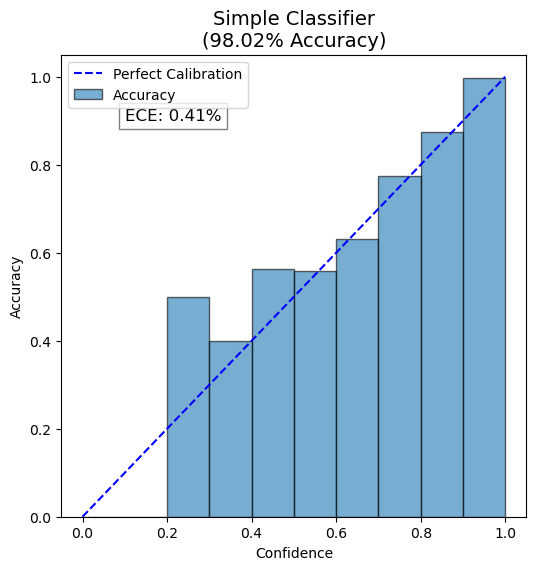

In [49]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_ece(confidences, predictions, labels, num_bins=10):
    """
    Calcula a Expected Calibration Error (ECE).
    """
    bins = np.linspace(0, 1, num_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    bin_accs = []
    bin_confs = []
    bin_sizes = []

    for i in range(num_bins):
        bin_mask = (confidences >= bins[i]) & (confidences < bins[i + 1])
        bin_size = bin_mask.sum().item()
        if bin_size > 0:
            bin_acc = (predictions[bin_mask] == labels[bin_mask]).float().mean().item()
            bin_conf = confidences[bin_mask].mean().item()
        else:
            bin_acc = 0
            bin_conf = 0
        bin_accs.append(bin_acc)
        bin_confs.append(bin_conf)
        bin_sizes.append(bin_size)

    ece = sum((bin_sizes[i] / len(confidences)) * abs(bin_accs[i] - bin_confs[i]) for i in range(num_bins))
    return ece, bin_centers, bin_accs, bin_confs

def plot_reliability_diagram(ece, bin_centers, bin_accs, bin_confs, accuracy, title):
    plt.figure(figsize=(6, 6))
    plt.bar(bin_centers, bin_accs, width=0.1, edgecolor='k', alpha=0.6, label='Accuracy')
    plt.plot([0, 1], [0, 1], '--', color='blue', label='Perfect Calibration')
    plt.text(0.1, 0.9, f"ECE: {ece*100:.2f}%", fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    plt.title(f"{title}\n({accuracy*100:.2f}% Accuracy)", fontsize=14)
    plt.xlabel("Confidence")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

ece, bin_centers, bin_accs, bin_confs = calculate_ece(all_confidences, all_predictions, all_labels)
accuracy = (all_predictions == all_labels).float().mean().item()
plot_reliability_diagram(ece, bin_centers, bin_accs, bin_confs, accuracy, title="Simple Classifier")

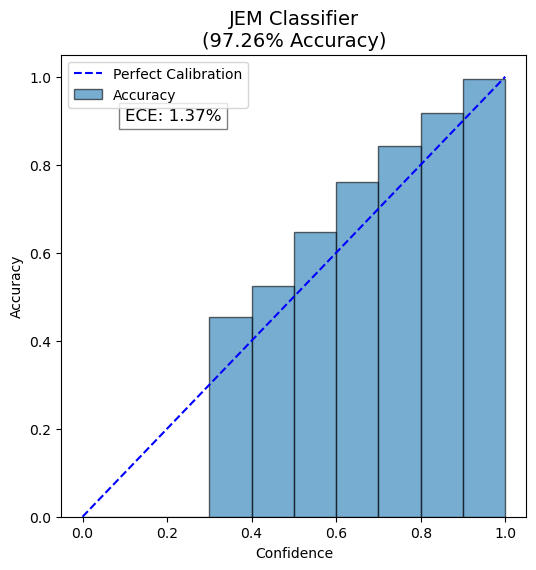

In [50]:
model.eval()
jem_confidences_list = []
jem_predictions_list = []
jem_labels_list = []

with torch.no_grad():
    for val_imgs, val_labels in val_loader:
        val_imgs, val_labels = val_imgs.to(device), val_labels.to(device)
        
        _, jem_logits = model(val_imgs)
        jem_probabilities = torch.softmax(jem_logits, dim=1)
        jem_predictions = torch.argmax(jem_probabilities, dim=1)
        
        jem_confidences_list.append(jem_probabilities.max(dim=1).values.cpu())
        jem_predictions_list.append(jem_predictions.cpu())
        jem_labels_list.append(val_labels.cpu())

jem_all_confidences = torch.cat(jem_confidences_list)
jem_all_predictions = torch.cat(jem_predictions_list)
jem_all_labels = torch.cat(jem_labels_list)

jem_ece, jem_bin_centers, jem_bin_accs, jem_bin_confs = calculate_ece(
    jem_all_confidences, jem_all_predictions, jem_all_labels
)
jem_accuracy = (jem_all_predictions == jem_all_labels).float().mean().item()

plot_reliability_diagram(
    jem_ece, jem_bin_centers, jem_bin_accs, jem_bin_confs, jem_accuracy, title="JEM Classifier"
)

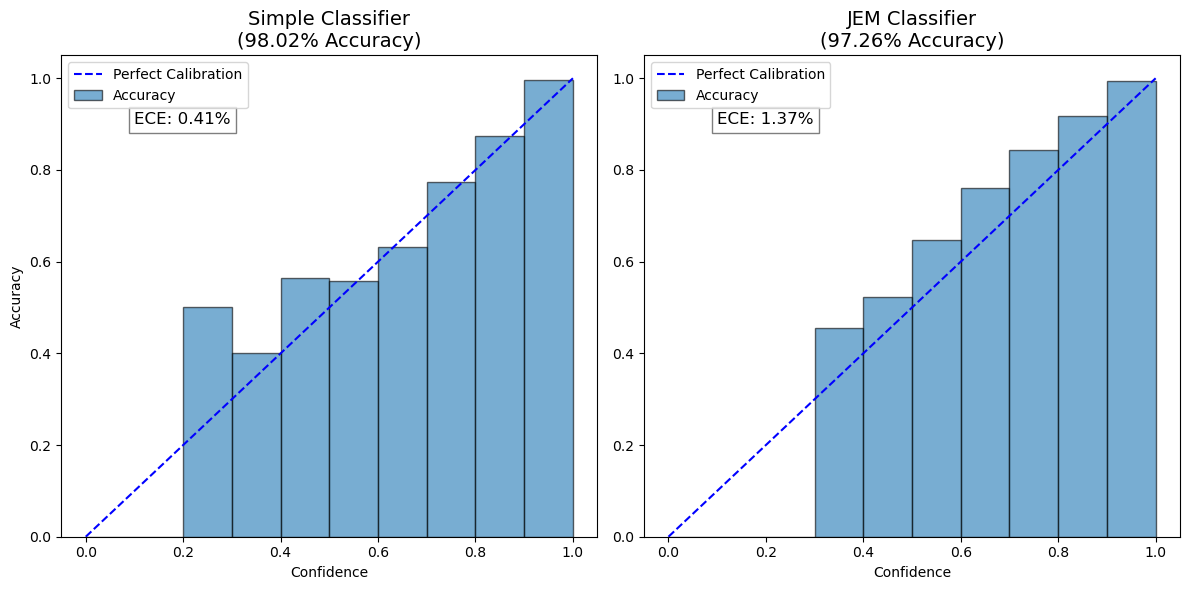

In [51]:
def plot_reliability_comparison(simple_data, jem_data):
    simple_ece, simple_bin_centers, simple_bin_accs, simple_bin_confs, simple_accuracy = simple_data
    jem_ece, jem_bin_centers, jem_bin_accs, jem_bin_confs, jem_accuracy = jem_data

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].bar(simple_bin_centers, simple_bin_accs, width=0.1, edgecolor='k', alpha=0.6, label='Accuracy')
    axes[0].plot([0, 1], [0, 1], '--', color='blue', label='Perfect Calibration')
    axes[0].text(0.1, 0.9, f"ECE: {simple_ece*100:.2f}%", fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    axes[0].set_title(f"Simple Classifier\n({simple_accuracy*100:.2f}% Accuracy)", fontsize=14)
    axes[0].set_xlabel("Confidence")
    axes[0].set_ylabel("Accuracy")
    axes[0].legend()

    axes[1].bar(jem_bin_centers, jem_bin_accs, width=0.1, edgecolor='k', alpha=0.6, label='Accuracy')
    axes[1].plot([0, 1], [0, 1], '--', color='blue', label='Perfect Calibration')
    axes[1].text(0.1, 0.9, f"ECE: {jem_ece*100:.2f}%", fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    axes[1].set_title(f"JEM Classifier\n({jem_accuracy*100:.2f}% Accuracy)", fontsize=14)
    axes[1].set_xlabel("Confidence")
    axes[1].legend()

    plt.tight_layout()
    plt.show()


simple_data = (ece, bin_centers, bin_accs, bin_confs, accuracy)

jem_data = (jem_ece, jem_bin_centers, jem_bin_accs, jem_bin_confs, jem_accuracy)

plot_reliability_comparison(simple_data, jem_data)

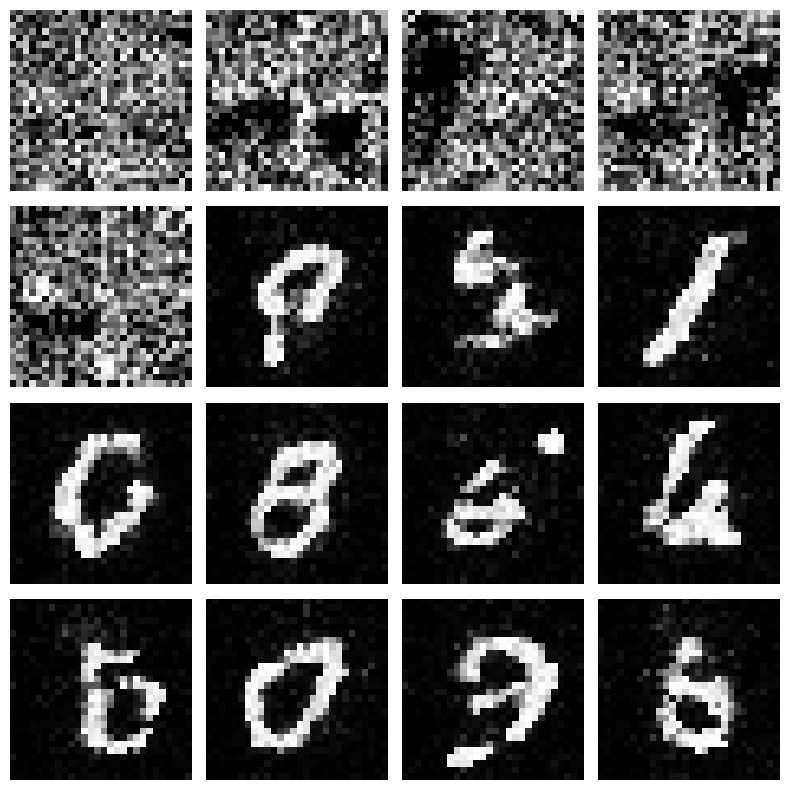

In [52]:
def generate_images_with_sampler(model, sampler, num_images=16, steps=60, step_size=10):
    model.eval()
    with torch.no_grad():
        generated_imgs = sampler.sample_new_exmps(steps=steps, step_size=step_size)
        generated_imgs = generated_imgs[:num_images].detach() 

    return generated_imgs.cpu()


def plot_generated_images(images, num_cols=4):
    num_images = images.size(0)
    num_rows = (num_images + num_cols - 1) // num_cols

    images = (images + 1) / 2 

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < num_images:
            img = images[i].squeeze(0).numpy()
            ax.imshow(img, cmap="gray")
            ax.axis("off")
        else:
            ax.axis("off")
    plt.tight_layout()
    plt.show()


num_images = 16
generated_images = generate_images_with_sampler(model, sampler, num_images=num_images, steps=2000, step_size=0.1)

plot_generated_images(generated_images)